In [41]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import shap
import xgboost as xgb


from matplotlib.colors import LinearSegmentedColormap

from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from src.data_processing.pipelines.ClassifierPipe import ClassifierPipe


# Reproduce processing pipeline 

In [52]:
DATA_PATH = '/Users/mds8301/iterm_data_storage/raw_data_raw_data.parquet.gzip'
SUBJECT_ID_PATH = '/Users/mds8301/Development/ENIGMA/results/experiments/xgb_regression_hyperopt/subjects.json'

processor_pipe = (ClassifierPipe(DATA_PATH)
                      .read_raw_data()
                      .calculate_max_min_signal()
                      .calculate_percent_avoid()
                      .query_by_col(query = "event == 'cue'")
                      .query_by_col(query = "sensor == 'DA'")
                      .drop_features(["sex", "event", "day", "action", "trial", "trial_count", "num_avoids", "max_trial"])
                      .split_data(target = "ratio_avoid",
                                load_subject_ids = True, 
                                subject_ids_path = SUBJECT_ID_PATH, 
                                save_subject_ids=False)
                      .transform_data()
)
processor_pipe.processed_data

,mouse_id,sensor,signal_max,signal_min,signal_trapz,pos_signal_trapz,neg_signal_trapz,ratio_avoid
15,0,DA,2.287195,-2.712690,-29.902420,154.878998,-184.781433,0.178571
16,0,DA,3.183504,-2.207469,67.867935,212.627350,-144.759415,0.178571
17,0,DA,2.618372,-3.175299,-18.871576,160.907135,-179.778717,0.178571
18,0,DA,2.474569,-2.778508,-31.325714,161.659180,-192.984894,0.178571
19,0,DA,3.101258,-2.721624,69.602921,210.729111,-141.126190,0.178571
...,...,...,...,...,...,...,...,...
12411,13,DA,3.848572,-2.235214,59.995239,253.057175,-193.061951,1.000000
12412,13,DA,3.930690,-2.136967,54.199169,203.687973,-149.488800,1.000000
12413,13,DA,2.873665,-2.285811,-33.815475,155.181824,-188.997314,1.000000
12414,13,DA,3.421153,-1.612487,176.095413,274.197083,-98.101654,1.000000


# Train Regressor using opimtized parameteres

In [69]:
best_params = {'booster': 'gbtree', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 250, 'reg_lambda': 1.0, 'subsample': 0.8}

model = xgb.XGBRegressor(
        objective='reg:squarederror', 
        eval_metric=['rmse', 'mae'],
        **best_params)
model.fit(processor_pipe.X_train, processor_pipe.y_train)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['rmse', 'mae'],
             feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=7, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=250,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

# Evalulatuation

In [72]:

from sklearn.metrics import mean_squared_error
mse_train = mean_squared_error(processor_pipe.y_train, model.predict(processor_pipe.X_train))
mse_dev = mean_squared_error(processor_pipe.y_dev, model.predict(processor_pipe.X_dev))
mse_test = mean_squared_error(processor_pipe.y_test, model.predict(processor_pipe.X_test))
print(f" MSE for optimzied model on train is {mse_train}")
print(f" MSE for optimzied model on development test is {mse_dev}")
print(f" MSE for optimzied model on test is {mse_test}")

 MSE for optimzied model on train is 0.01281378853432466
 MSE for optimzied model on development test is 0.10700600031459778
 MSE for optimzied model on test is 0.09087149944116703


# Predict on test set

In [79]:
predicted_performance = model.predict(processor_pipe.X_test)

# Plotting test set vs inference 


In [74]:
def get_cols_from_pipeline(pipeline):
        num_cols = pipeline.processor.named_transformers_["num"].get_feature_names_out().tolist()
        cat_cols = pipeline.processor.named_transformers_["cat"].get_feature_names_out().tolist()
        return num_cols + cat_cols
def get_df_from_pipeline(pipeline, predicted_values):
        cols = get_cols_from_pipeline(pipeline)
        
        df = (pd.DataFrame(pipeline.X_test, columns=cols)
              .assign(predicted_values = predicted_values, 
                      true_values = pipeline.y_test.values))
        values_cat = ['predicted_values', 'true_values']

        return  (
                df
                .melt(id_vars = [col for col in df.columns if col not in values_cat],
                value_vars = values_cat, 
                var_name = "inference_cat",
                value_name='ratio_avoid')
        )
                
testing_df = get_df_from_pipeline(processor_pipe, predicted_performance)
testing_df

,mouse_id,signal_max,signal_min,signal_trapz,pos_signal_trapz,neg_signal_trapz,sensor_DA,inference_cat,ratio_avoid
0,-0.255589,2.615386,0.374272,0.229392,0.115291,0.279192,1.0,predicted_values,0.873940
1,-0.255589,1.813498,-0.951865,-1.324179,-0.370989,-1.857539,1.0,predicted_values,0.833625
2,-0.255589,2.960508,0.732214,0.455327,0.307140,0.488813,1.0,predicted_values,0.788747
3,-0.255589,0.759592,-0.400363,-0.383607,-0.693433,-0.048943,1.0,predicted_values,0.789855
4,-0.255589,0.001935,0.889831,-0.683625,-1.259174,-0.067679,1.0,predicted_values,0.567675
...,...,...,...,...,...,...,...,...,...
1131,1.592563,-0.749555,-0.208662,0.376571,0.259959,0.399303,1.0,true_values,0.928571
1132,1.592563,-0.746200,-0.665089,-1.063608,-0.983603,-0.919643,1.0,true_values,0.928571
1133,1.592563,-0.563064,0.036053,-0.681121,-0.995814,-0.283440,1.0,true_values,0.928571
1134,1.592563,-0.408064,-0.563574,0.512799,0.723424,0.235352,1.0,true_values,0.928571


---
# Feature Importance


<Axes: xlabel='ratio_avoid', ylabel='signal_min'>

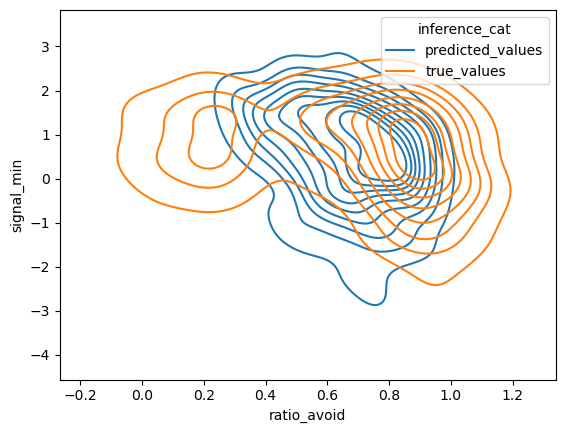

In [83]:
sns.kdeplot(data=testing_df, x="ratio_avoid", y="signal_min", hue="inference_cat")

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


Text(0.5, 1.0, 'Feature Importance')

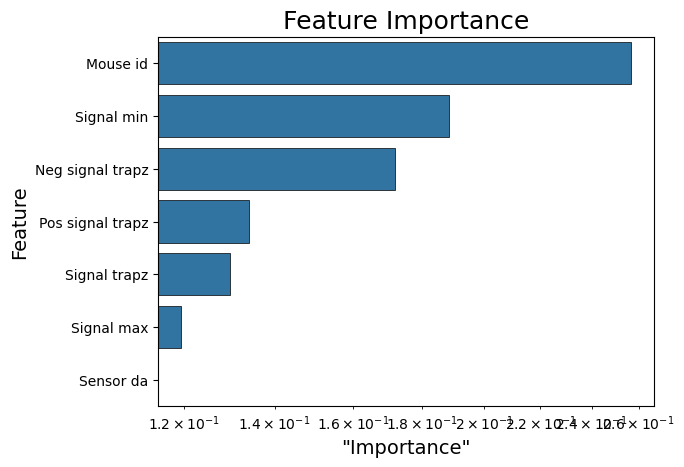

In [75]:
cols = get_cols_from_pipeline(processor_pipe)
feature_importance = (
    pd.Series(
    model.feature_importances_, index = cols)
    .sort_values(ascending=False)
)
feature_importance
col_labels = [col.capitalize().replace('_', ' ') for col in feature_importance.index]
fig, ax = plt.subplots()
sns.barplot(x=feature_importance, y=feature_importance.index, ax=ax, linewidth=0.5, edgecolor='black')
ax.set_yticklabels(col_labels)
ax.set_xscale("log")
ax.set_xlabel('"Importance"', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
ax.set_title('Feature Importance', fontsize = 18)

## SHAP from feature space

In [84]:
shap_values = shap.TreeExplainer(model).shap_values(processor_pipe.X_test)
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(processor_pipe.X_test)

[15:20:42] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [77]:
explainer = shap.TreeExplainer(model, processor_pipe.X_train)
shap_values = explainer(processor_pipe.X_train)

# np.abs(shap_values.sum(axis=1) + explanation.base_values - predicted_performance).max()
# 0.0

[15:16:39] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


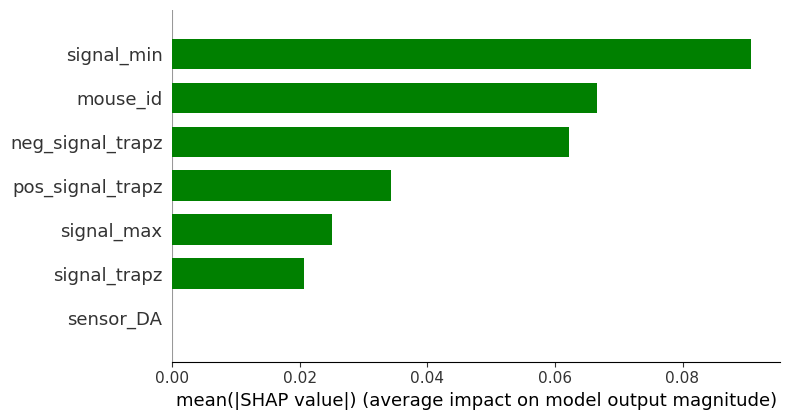

In [78]:
shap.summary_plot(shap_values, 
                  processor_pipe.X_test,
                  plot_type = 'bar',
                  color = 'green',
                  feature_names = cols)


## Dimentional Reduction of SHAP

In [86]:
shap_values[0]

array([ 0.02400324,  0.0538427 ,  0.03940699, -0.00705749,  0.01323605,
        0.04779301,  0.        ], dtype=float32)

<Axes: >

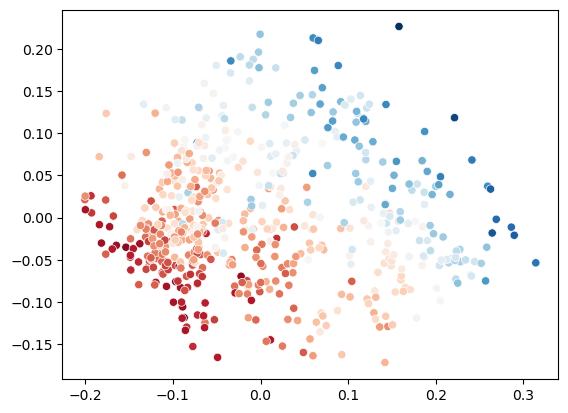

In [87]:
shap_pca = PCA(n_components=2).fit_transform(shap_values)
sns.scatterplot(x=shap_pca[:,0], y=shap_pca[:,1], c = shap_values.sum(1), cmap="RdBu_r")